# Receiving and demodulating FM signals using AD9361

In this notebook, we will use AD9361 to receive a real-world FM signal and demodulate it.

# 1. Receiving and analyzing the whole FM band

First, import the `adi` module and instantiate the `adi.adi9361()` object. This allows us to control the AD9361 device.

See [pyadi_iio](https://github.com/analogdevicesinc/pyadi-iio) for details of the `adi` module.

In [1]:
import adi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

sdr = adi.ad9361()

Then, we start by looking at which frequencies the FM radios are at.

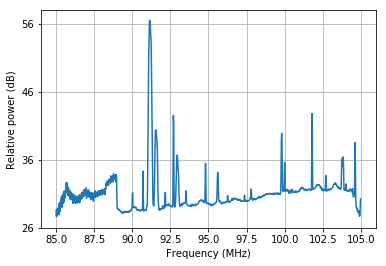

In [2]:
# 1) set down some important global variables
bw = 20_000_000    # bandwidth
fc = 95_000_000    # center frequency
fs = 20_000_000    # sample rate
ns = fs  # number of samples

# 2) configure the relevant properties of AD9361.

# 2.1) ensure safety
sdr.ctx.set_timeout(5_000)
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()

# 2.2) gain control
sdr.gain_control_mode = 'slow_attack'

# 2.3) channel num
sdr.rx_enabled_channels = [0]
sdr.tx_enabled_channels = [0]

# 2.4) rx config
sdr.rx_lo = fc
sdr.rx_rf_bandwidth = bw
sdr.rx_buffer_size = ns
sdr.sample_rate = fs

# 3) receive to buffer 
samples = sdr.rx()

# 4) analyze the frequency band
plt.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')

plt.show()

As shown above, there are several narrow peaks, which indicates where the FM radio signals are at.

We will select the peak at around 92.7 MHz. You can verify the peak frequency by using a portable FM radio receiver.

# 2. Receiving FM signals from a specific radio station

Next, we receive the signals around the center frequency 92.7 MHz, and then demodulate it into audio signals.

We can write a simple class for future convenience.

In [3]:
import adi
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

class FMRadio(adi.ad9361):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rx_destroy_buffer()
        self.tx_destroy_buffer()
        self.rx_enabled_channels = [0]
        self.tx_enabled_channels = [0]
        
    def config_rx(self, fc=92_700_000, bw=200_000, fs=2_400_000, ns=2_400_000):
        self.ctx.set_timeout(1000 * int(np.ceil(ns / fs)))
        self.rx_lo = fc
        self.rx_rf_bandwidth = bw
        self.sample_rate = fs
        self.rx_buffer_size = ns
        

In [4]:
# 1) set down some important global variables
fc = 92_700_000   # center frequency
bw = 200_000    # bandwidth
fs = 2_400_000    # sample rate
ns = 2 * fs      # number of samples

# 2) configure the relevant properties of AD9361.
del sdr
fmradio = FMRadio()
fmradio.config_rx(fc=fc, bw=bw, fs=fs, ns=ns)

# 3) receive to buffer 
samples = fmradio.rx()

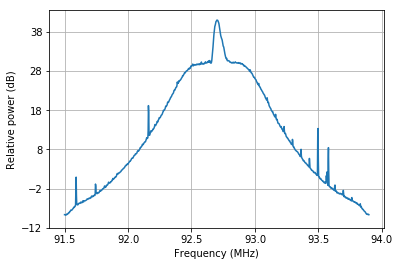

In [5]:
plt.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')

plt.show()

Now the 92.7MHz FM signal is selected out.

Note that we have set the bandwidth to 200kHz, which automatically filters out FM signals at other frequencies.

---

Next, we can save the samples for future reproducibility.

In [6]:
np.save("samples_received", samples)

# 3. Demodulating the FM samples

Next let's define the functions we have already developed in the first notebook.

In [7]:
def downsample(x, M, p=0):  
    if not isinstance(M, int):
        raise TypeError("M must be an int")
    x = x[0:int(np.floor(len(x) / M)) * M]
    x = x.reshape((int(np.floor(len(x) / M)), M))
    y = x[:,p]
    return y

def fm_discrim(x):
    X = np.real(x)
    Y = np.imag(x)
    b = np.array([1, -1])
    dY = signal.lfilter(b, 1, Y)
    dX = signal.lfilter(b, 1, X)
    discriminated = (X * dY - Y * dX) / (X**2 + Y**2 + 1e-10)
    return discriminated

def fm_audio(samples, fs=2.4e6, fc=92.7e6, fc1=200e3, fc2=12e3, d1=10, d2=5, plot=False):
    lpf_b1 = signal.firwin(64, fc1/(float(fs)/2))
    lpf_b2 = signal.firwin(64, fc2/(float(fs)/d1/2))
    
    # 1st filtering
    samples_filtered_1 = signal.lfilter(lpf_b1, 1, samples)
    # 1st decimation
    samples_decimated_1 = downsample(samples_filtered_1, d1)
    # phase discrimination
    samples_discriminated = fm_discrim(samples_decimated_1)
    # 2nd filtering
    samples_filtered_2 = signal.lfilter(lpf_b2, 1, samples_discriminated)
    # 2nd decimation
    audio = downsample(samples_filtered_2, d2)
    
    if plot:
        fig, ((ax0, ax1, ax2), (ax3, ax4, ax5)) = plt.subplots(2, 3, figsize=(15, 10))

        ax0.psd(samples, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax0.set_title("samples")
        ax0.set_xlabel('Frequency (MHz)')
        ax0.set_ylabel('Relative power (dB)')
        
        ax1.psd(samples_filtered_1, NFFT=1024, Fs=fs/1e6, Fc=fc/1e6)
        ax1.set_title("samples_filtered_1")
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax2.psd(samples_decimated_1, NFFT=1024, Fs=fs/d1/1e6, Fc=fc/1e6)
        ax2.title.set_text('samples_decimated_1')
        ax1.set_xlabel('Frequency (MHz)')
        ax1.set_ylabel('Relative power (dB)')

        ax3.psd(samples_discriminated, NFFT=1024, Fs=fs/d1, Fc=0)
        ax3.title.set_text('samples_discriminated')

        ax4.psd(samples_filtered_2, NFFT=1024, Fs=fs/d1, Fc=0)
        ax4.title.set_text('samples_filtered_2')
        
        ax5.psd(audio, NFFT=1024, Fs=fs/d1/d2, Fc=0)
        ax5.title.set_text('audio')

        plt.show()
        
        return audio, fig, (ax0, ax1, ax2, ax3, ax4, ax5)
    else:
        return audio

Finally, we can demodulate the received signals and enjoy listening!

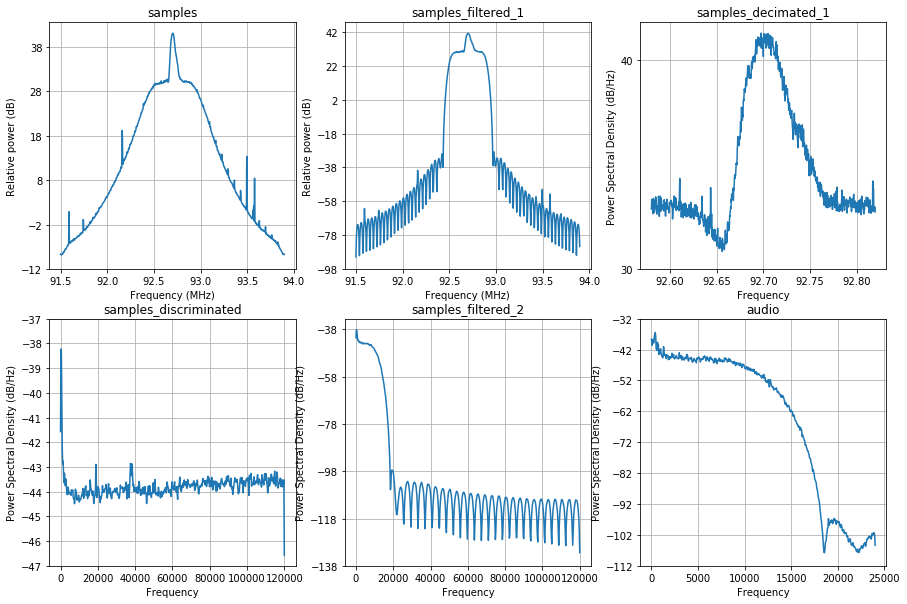

In [8]:
from IPython.display import Audio

audio, _, _ = fm_audio(samples, plot=True)
Audio(audio, rate=48000)

The quality of the output audio may depend on the size of your antenna, the location, and the surrounding environment.

# Conclusion

In this notebook, we used AD9361 (though pyadi_iio library) to receive FM signals. Then, we demodulated the signals using the techniques developed in the previous notebook.

In the next notebook, we will deploy hardware demodulation using FPGAs, which is significantly faster compared to the software implementation.

# Reference

The main reference of this notebook is [Parallel Programming for FPGAs](https://pp4fpgas.readthedocs.io/en/latest/project7.html), which is developed by [Kastner Research Group](https://github.com/KastnerRG).